In [1]:
#@title init
import pickle
import torch
import torch.nn.functional as F
import sys
import shutil
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.model_selection import train_test_split
import csv
import numpy as np
import pandas as pd
import PIL.Image
from PIL import Image, ImageDraw
import IPython.display
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from ipywidgets import interact, Button, FloatSlider, Layout
import sys

import io
import os, time
import pickle
import shutil
import numpy as np
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import copy
import unicodedata
import re
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from time import perf_counter

# df = pd.read_hdf('coords_wlosses.h5')
DATA_ROOT = Path("/Users/adamsobieszek/PycharmProjects/psychGAN/content/")  # adjust to your paths
CONFIG = {
    "means": DATA_ROOT / "omi/attribute_means.csv",
    "ratings": DATA_ROOT / "omi/attribute_ratings.csv",
    "dlatents": DATA_ROOT / "coords_wlosses.csv",
}
df = pd.read_csv('/Users/adamsobieszek/PycharmProjects/psychGAN/content/coords_wlosses.csv')

In [ ]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from torchvision.transforms import Compose, Resize
import torchvision.transforms.functional as TF
from typing import List, Dict, Union, Tuple

# Assuming the existence of these from a library like torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.models import *


from manipy.models.flow_models import VectorFieldTransformer, RatingODE
from manipy.models.layers import EnsembleRegressor, MeanRegressor
from manipy.models.rating_models import AlphaBetaRegressor


def sample_w(n, truncation_psi=1, device=None, **kwargs):
    """Samples N latent vectors (w) that pass certain filter criteria."""
    global G
    device = device or ('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    try:
        _G = G
        assert _G is not None, "G is not set. Use the 'G_context' manager. or pass G as an argument."
    except:
        G = kwargs.get("G", kwargs.get("_G", None))

    if G is None:
        class MockGenerator(nn.Module):
            mapping = MappingNetwork(512,0,512,18).to(device).load_state_dict(torch.load("/Users/adamsobieszek/PycharmProjects/_manipy/mapping_network/map (1).pt", weights_only=True, map_location=device))
        
        G = MockGenerator()
        print("'G' is not set. Use the 'G_context' manager. or pass G as an argument.")

    if G is None:
        raise ValueError("G is not set. Use the 'G_context' manager. or pass G as an argument.")
    _G = G
    device = device or _G.mapping.w_avg.device

    with torch.no_grad():
        all_z = torch.randn([n, 512], device=device)
        all_w = _G.mapping(all_z, None, truncation_psi=truncation_psi)[:, 0]
        return all_w
from manipy.models.rating_models import EnsembleRegressor, MeanRegressor

final_models_path = "/Users/adamsobieszek/PycharmProjects/psychGAN/content/"
device = torch.device('mps')

# if not os.path.exists("final_models"):
#   !gdown 1pPjOd-mx-d-vOw1QR_lpJoJmLAGdkI3W
#   !unzip final_models.zip
#   !unzip final_models.zip
control_names = ['happy', 'gender', 'age']
control_models = [EnsembleRegressor([MeanRegressor(512,1) for _ in range(8)], model_kwargs={}).to(device) for label in control_names]
for m,l in zip(control_models,control_names):
    m.load_state_dict(torch.load(f"{final_models_path}/final_models/ensemble_{l}.pt", map_location=torch.device("mps")))
    m.eval()



sys.path.append('/Users/adamsobieszek/PycharmProjects/psychGAN/content/psychGAN/stylegan3')
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:
    G = pickle.load(fp)['G_ema'].to(device)

# Compute the average latent vector
all_z = torch.randn([1, G.mapping.z_dim], device=device)
face_w = G.mapping(all_z, None, truncation_psi=0.5)

dim = "trustworthy"

models = [AlphaBetaRegressor(dim=512, w_avg=G.mapping.w_avg).to(device) for i in range(8)]
for i,m in enumerate([torch.load(f"/Users/adamsobieszek/PycharmProjects/psychGAN/best_models/{mm}",map_location=device) for mm in [f"model_{dim}_v{3+i}.pt" for i in range(8)]]):
    models[i].load_state_dict(m)
    models[i].eval()
model = EnsembleRegressor(models)

flow = VectorFieldTransformer(
    rating_model=model,
    dim=512,
    depth=8,
    num_heads=8,
    dim_head=48,
    num_registers=32,
    dropout=0.15,
    add_rating_gradient=True,
    use_rotary=True,
    w_avg=G.mapping.w_avg
).to(device)
flow.eval()
checkpoint_path =  '/Users/adamsobieszek/PycharmProjects/psychGAN/trustworthy_final_final_final.pt'
flow.load_state_dict(torch.load(checkpoint_path,map_location=device))


class StyleGANFlowBackend:
    def __init__(self,
                 generator: torch.nn.Module,
                 flow_models: Dict[str, torch.nn.Module],
                 regression_models: Dict[str, torch.nn.Module],
                 trait_stats_df: pd.DataFrame):
        """
        Initializes the StyleGANFlowBackend for flow-based manipulations.
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
        print(f"✅ StyleGANFlowBackend initialized on device: {self.device}")

        self.G = generator.to(self.device).eval()
        self.flow_models = {k: m.to(self.device).eval() for k, m in flow_models.items()}
        self.models = {k: m.to(self.device).eval() for k, m in regression_models.items()}
        self.dimension_names = [*self.flow_models.keys()]
        self.df = trait_stats_df
        self.m, self.std = trait_stats_df[self.dimension_names].mean(), trait_stats_df[self.dimension_names].std()

    def to_w(self, target: Union[str, Path, np.ndarray, torch.Tensor]) -> torch.Tensor:
        # ... (same as before) ...
        if isinstance(target, (str, Path)):
            target = np.load(target) if ".npy" in str(target) else torch.load(target)
        if isinstance(target, np.ndarray):
            target = torch.tensor(target, dtype=torch.float32, device=self.device)
        if target.dim() < 2: target = target.reshape(1, 1, 512)
        if target.dim() == 2: target = target.unsqueeze(0)
        if target.shape[1] == 1: target = target.repeat(1, 18, 1)
        return target.to(self.device).reshape(-1, 18, 512)

    def _get_adaptive_steps(self, min_steps: int, num_levels: int) -> int:
        """Calculates the optimal number of steps for the trajectory."""
        if num_levels == 0:
            return min_steps
        # Ensure we have at least min_steps
        num_steps = max(min_steps, num_levels)
        # If not perfectly divisible, find the next multiple of num_levels
        if num_steps % num_levels != 0:
            num_steps = ((num_steps // num_levels) + 1) * num_levels
        return num_steps

    def _calculate_efficient_trajectory(self,
                                        target_dim: str,
                                        strengths_in_direction: List[float],
                                        initial_w_for_flow: torch.Tensor,
                                        min_steps: int,
                                        is_forward: bool) -> Dict[float, torch.Tensor]:
        """
        Calculates one trajectory and samples all required points from it.
        """
        if not strengths_in_direction:
            return {}

        # 1. Determine trajectory parameters
        max_strength = max(abs(s) for s in strengths_in_direction)
        num_levels = len(strengths_in_direction)
        num_steps = self._get_adaptive_steps(min_steps, num_levels)
        t_span = torch.linspace(0, max_strength, num_steps, device=self.device)

        # 2. Set up the ODE solver for this specific trajectory
        flow_field = self.flow_models[target_dim]
        rating_model = self.models[target_dim]
        # The NeuralODE solver needs to be re-initialized for correct direction
        
        from torchdiffeq import odeint
        ode_func = lambda t, w: (1 if is_forward else -1)*flow_field(w)
        t_span = torch.linspace(0, 2.5, num_steps, device=self.device)
        full_trajectory = odeint(ode_func, initial_w_for_flow, t_span, method='rk4')
        
        

        # 3. Compute the single, full trajectory
        print(f"🚀 Computing {'forward' if is_forward else 'backward'} trajectory for '{target_dim}' with {num_steps} steps to strength {max_strength:.2f}...")

        # 4. Sample the required points from the trajectory
        results = {}
        for s in strengths_in_direction:
            # Find the index in the trajectory corresponding to this strength
            s_abs = abs(s)
            idx = round((s_abs / max_strength) * (num_steps - 1)) if max_strength > 0 else 0
            results[s] = full_trajectory[int(idx)]
        return results

    @torch.no_grad()
    def __call__(self,
                 manipulated_dimensions: List[str],
                 strengths: List[float] = [1.0],
                 num_faces: int = 1,
                 steps: int = 10,
                 latents_from: int = 0,
                 latents_to: int = 18,
                 preserve_identity: bool = True,
                 truncation_psi: float = 0.55,
                 max_batch_size: int = 4,
                 return_coords: bool = False,
                 return_metadata: bool = False,
                 w: torch.Tensor = None,
                 **kwargs) -> Union[Tuple, Tuple[List, List, torch.Tensor], Tuple[List, List, torch.Tensor, Dict]]:

        # --- 1. Initial Setup ---
        def to_pil(images):
            tf = Compose([Resize(512), lambda x: torch.clamp((x + 1) / 2, 0, 1)])
            return [TF.to_pil_image(img) for img in tf(images)]
        
        def predict_ratings(w_tensor):
            w0 = w_tensor[:, 0, :]
            return {label: model(w0).cpu() for label, model in self.models.items()}

        if num_faces > 1:
            # The efficient calculation logic assumes all manipulations apply to the same set of faces.
            print("⚠️ Warning: Efficient trajectory calculation is optimized for `num_faces=1`. Running for multiple faces may have unintended effects if they diverge significantly.")

        face_w = self.to_w(w) if w is not None else self.G.mapping(torch.randn([num_faces, self.G.z_dim], device=self.device), None, truncation_psi=truncation_psi)
        w_for_flow = face_w[:, 0, :]

        # --- 2. Efficiently Compute All Manipulations ---
        all_manipulated_w0 = {}
        target_dim = manipulated_dimensions[0] # Assuming one dimension for now

        unique_strengths = sorted(list(set(strengths)))
        pos_strengths = [s for s in unique_strengths if s >= 0]
        neg_strengths = [s for s in unique_strengths if s < 0]

        # Handle positive and zero strengths
        if pos_strengths:
            pos_results = self._calculate_efficient_trajectory(target_dim, pos_strengths, w_for_flow, steps, is_forward=True)
            all_manipulated_w0.update(pos_results)

        # Handle negative strengths
        if neg_strengths:
            neg_results = self._calculate_efficient_trajectory(target_dim, neg_strengths, w_for_flow, steps, is_forward=False)
            all_manipulated_w0.update(neg_results)

        # --- 3. Assemble Final Results ---
        images_pil = to_pil(self.G.synthesis(face_w).cpu())
        labels = [f"{i}_original" for i in range(num_faces)]
        coords = face_w.clone()
        metadata = {"initial_ratings": [], "final_ratings": [], "manipulation": [], "distance": []}
        initial_ratings = predict_ratings(face_w)

        print(" assembling final images...")
        for strength in unique_strengths:
            if strength == 0: continue # The original is already included
            
            w0 = all_manipulated_w0[strength]
            manipulated_w_final = face_w.clone()
            manipulated_w_final[:, :, :] = w0.unsqueeze(1)

            if preserve_identity:
                style_layers = range(latents_from, latents_to, 2)
                manipulated_w_final[:, style_layers, :] = face_w[:, style_layers, :]
            
            images_pil.extend(to_pil(self.G.synthesis(manipulated_w_final).cpu()))
            coords = torch.cat((coords, manipulated_w_final))
            
            name = f"{target_dim}_{strength:+.2f}"
            labels.extend([f"{i}_{name}" for i in range(num_faces)])
            
            if return_metadata:
                metadata["initial_ratings"].append({k: v.numpy() for k, v in initial_ratings.items()})
                metadata["final_ratings"].append({k: v.numpy() for k, v in predict_ratings(manipulated_w_final).items()})
                metadata["manipulation"].append(name)
                metadata["distance"].append(torch.norm(manipulated_w_final[:, 0, :] - face_w[:, 0, :], dim=-1).cpu().numpy())

        # --- 4. Format Output ---
        output = (images_pil, labels)
        if return_coords: output += (coords.cpu(),)
        if return_metadata: output += (metadata,)
        
        return output
#
backend = StyleGANFlowBackend(
    generator=G,
    flow_models={"trustworthy": flow, "attractive": flow},
    regression_models={"trustworthy": model}|dict([(l,m) for l,m in zip(control_names,control_models)]), # Can now have multiple named models
    trait_stats_df=df
)
backend

✅ StyleGANFlowBackend initialized on device: mps


/opt/anaconda3/envs/manip311/lib/python3.11/site-packages/torch/__init__.py:1618: UserWarning: This API is going to be deprecated, please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/Context.cpp:81.)
  _C._set_float32_matmul_precision(precision)


# Frontend

In [3]:
config = {
  "manipulated_dimensions": [
    {
      "name": "trustworthy",
      "strength": 1.5,
      "n_levels": 5
    },
    {
      "name": "attractive",
      "strength": -2.0,
      "n_levels": 4
    }
  ],
  "truncation_psi": 0.8,
  "num_faces": 5,
  "max_steps": 100,
  "preserve_identity": True,
}


config["num_faces"]=1
config["return_metadata"]=True
config["return_coords"]=True

images_pil, labels, coords, metadata = backend(config)
image_array = images_pil[1:]
converted_images = []
print(config)
for img in image_array:
    # Convert PIL Image to bytes
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()

    # Encode bytes to base64 string
    converted_images.append(base64.b64encode(img_byte_arr).decode('utf-8'))

converted_images


KeyError: 0

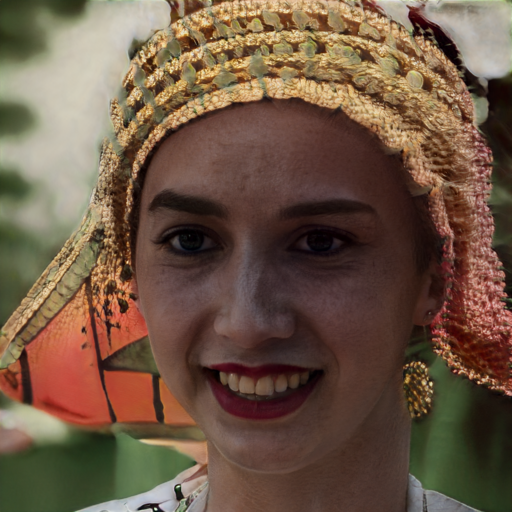

In [ ]:
PIL.Image.open(io.BytesIO(base64.b64decode(converted_images[0])))

In [ ]:
!rm -rf psych_gen_app
!git clone https://github.com/Szirle/psych_gen_app
%cd psych_gen_app/build

Cloning into 'psych_gen_app'...
remote: Enumerating objects: 482, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 482 (delta 0), reused 2 (delta 0), pack-reused 474 (from 1)
Receiving objects: 100% (482/482), 48.20 MiB | 1.13 MiB/s, done.
Resolving deltas: 100% (192/192), done.
/Users/adamsobieszek/PycharmProjects/_manipy/psych_gen_app/build/psych_gen_app/build


In [ ]:

%cd psych_gen_app/build
from flask import Flask, send_from_directory, jsonify, request
import os
import io
import base64
from pyngrok import ngrok
import time
import json

class RatingODE(nn.Module):
    def __init__(self, flow, rating_model, reverse = False):
        super().__init__()
        self.flow = flow
        self.rating_model = rating_model
        self.history = []
        self.reverse = reverse

    def forward(self, x):
        with torch.no_grad():
            x = x[:,:512]
            r = self.rating_model(x)
            r = torch.logit(r[:,:1]/(r[:,:1]+r[:,1:]))
            # self.history.append(r.cpu())
        return self.flow(x,r)*(-1 if self.reverse else 1)/5
    
# ngrok.set_auth_token("2lnXo9MM2mYuz4I1Kav5wemmbKm_3eCGC4FSngzvHBdz4Meeu")
app = Flask(__name__, static_folder='web')

# public_url = ngrok.connect(5000)

@app.route('/')
def index():
    return send_from_directory(app.static_folder, 'index.html')

@app.route('/<path:path>')
def static_files(path):
    return send_from_directory(app.static_folder, path)

def parse_config(conf):
    """
    Zamienia przychodzący JSON na słownik akceptowany przez StyleGANBackend.
    • Dla każdego wymiaru zwraca *listę py-floatów*, a nie tablicę NumPy.
      Dzięki temu dalsze mnożenie (float * Tensor) działa bez błędu.
    """
    if isinstance(conf, str):
        conf = json.loads(conf)
    print(json.dumps(conf, indent=2))
    
    latents_from, latents_to = {"both": (0,18), "color": (9,18), "shape":(0,9)}[conf.pop("mode", "both")]
    
    dim1 = conf["manipulated_dimensions"][0]
    conf["manipulated_dimensions"] = [dim1["name"]]
    # Note: np.linspace includes start and end points
    conf["strengths"] = [*np.linspace(-1*dim1["strength"], dim1["strength"], dim1["n_levels"])]
    print(conf["strengths"])
    conf["steps"] = min(5,conf.pop("max_steps", 5))
    conf["latents_from"] = latents_from
    conf["latents_to"] = latents_to
    # dims = conf["manipulated_dimensions"]
    # conf["manipulated_dimensions"] = [d["name"] for d in dims]

    # # ← kluczowa linia: tolist() zamienia ndarray na zwykłą listę floatów
    # if (len(dims) == 1):
    #   conf["strengths"] = [
    #       *np.linspace(-1*dims[0]["strength"], dims[0]["strength"], dims[0]["n_levels"])
    #   ]
    # elif (len(dims) == 2):
    #      conf["strengths"] = [
    #       *np.linspace(-1*dims[0]["strength"], dims[0]["strength"], dims[0]["n_levels"])
    #       *np.linspace(-1*dims[1]["strength"], dims[1]["strength"], dims[1]["n_levels"])
    #   ]
    print(conf)
    return conf

@app.route('/images', methods=['POST'])
def convert_images():
      config = request.json
      config = parse_config(config)
      config["num_faces"]=1
      config["return_metadata"]=True
    
      images_pil, labels = backend(**config)
      image_array = images_pil[1:]
      converted_images = []
      print(labels)
      for img in image_array:
          # Convert PIL Image to bytes
          img_byte_arr = io.BytesIO()
          img.save(img_byte_arr, format='PNG')
          img_byte_arr = img_byte_arr.getvalue()

          # Encode bytes to base64 string
          converted_images.append(base64.b64encode(img_byte_arr).decode('utf-8'))

      return converted_images


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5002)#debug=True)

/Users/adamsobieszek/PycharmProjects/_manipy/psych_gen_app/build
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5002
 * Running on http://10.246.87.239:5002
Press CTRL+C to quit


In [ ]:
config = {
  "manipulated_dimensions": [
    {
      "name": "trustworthy",
      "strength": 1.5,
      "n_levels": 3
    },
    {
      "name": "attractive",
      "strength": -2.0,
      "n_levels": 4
    }
  ],
  "truncation_psi": 0.8,
  "num_faces": 5,
  "max_steps": 100,
  "preserve_identity": True,
}


config = parse_config(config)
config["num_faces"]=1
config["return_metadata"]=True

images_pil, labels = backend(config)
image_array = images_pil[1:]
converted_images = []
print(labels)
for img in image_array:
    # Convert PIL Image to bytes
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()

    # Encode bytes to base64 string
    converted_images.append(base64.b64encode(img_byte_arr).decode('utf-8'))

converted_images


NameError: name 'parse_config' is not defined